### Modeling Chicago Apartment Rental Price Using Craiglist Data
In this notebook, we are going to explore citi of chicago's apartment listings. The data was scraped fro

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_json('../data/chicago_craiglist_housing.json')

In [3]:
df.shape

(3590, 11)

In [4]:
df.head()

,area,baths,beds,latitude,link,longitude,others,postdate,postid,price,title
0,NaN,2.0,3.0,41.928032,https://chicago.craigslist.org/chc/apa/d/chica...,-87.699956,NaN,Apr 11,6863762705,3900,"3 Bed in Converted Church on W Logan Blvd., 2 ..."
1,NaN,1.0,3.0,41.909285,https://chicago.craigslist.org/chc/apa/d/chica...,-87.707120,NaN,Apr 11,6854505706,1595,Spacious 3BD apt in Humboldt Park w/ Central A...
2,NaN,1.0,0.0,41.992631,https://chicago.craigslist.org/chc/apa/d/chica...,-87.658656,NaN,Apr 11,6863749119,1125,***FANTASTIC LAYOUT ON THIS NEW STUDIO - CLICK...
3,NaN,1.0,1.0,41.952889,https://chicago.craigslist.org/chc/apa/d/chica...,-87.664369,NaN,Apr 11,6850315434,1300,LAKEVIEW: 1 BED 1 BATH HDWD LAUNDRY IN BUILDIN...
4,NaN,2.0,3.0,41.862451,https://chicago.craigslist.org/chc/apa/d/chica...,-87.624011,NaN,Apr 11,6846164626,3690,SOUTH LOOP: 3 BED 2 BATH HI RISE PET FRIENDLY ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3590 entries, 0 to 3589
Data columns (total 11 columns):
area         971 non-null float64
baths        3520 non-null float64
beds         3541 non-null float64
latitude     3590 non-null object
link         3590 non-null object
longitude    3590 non-null object
others       971 non-null object
postdate     3590 non-null object
postid       3590 non-null int64
price        3590 non-null int64
title        3590 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 308.6+ KB


In [6]:
#df['beds'] = df['beds'].str.replace('BR', '').astype('float')
#df['baths'] = df['baths'].str.replace('Ba', '').astype('float')
#df['price'] = df['price'].str.replace('$', '').astype('float')

In [7]:
df = df[['link','title','postdate', 'latitude', 'longitude', 'beds', 'baths', 'area', 'others', 'price']]

In [8]:
df.head(3)

,link,title,postdate,latitude,longitude,beds,baths,area,others,price
0,https://chicago.craigslist.org/chc/apa/d/chica...,"3 Bed in Converted Church on W Logan Blvd., 2 ...",Apr 11,41.928032,-87.699956,3.0,2.0,NaN,NaN,3900
1,https://chicago.craigslist.org/chc/apa/d/chica...,Spacious 3BD apt in Humboldt Park w/ Central A...,Apr 11,41.909285,-87.707120,3.0,1.0,NaN,NaN,1595
2,https://chicago.craigslist.org/chc/apa/d/chica...,***FANTASTIC LAYOUT ON THIS NEW STUDIO - CLICK...,Apr 11,41.992631,-87.658656,0.0,1.0,NaN,NaN,1125


[Text(0, 0, 'beds'),
 Text(0, 0, 'baths'),
 Text(0, 0, 'area'),
 Text(0, 0, 'others')]

Text(0.5, 0, 'Count of missing values')

Text(0.5, 1.0, 'Number of missing values in each column')

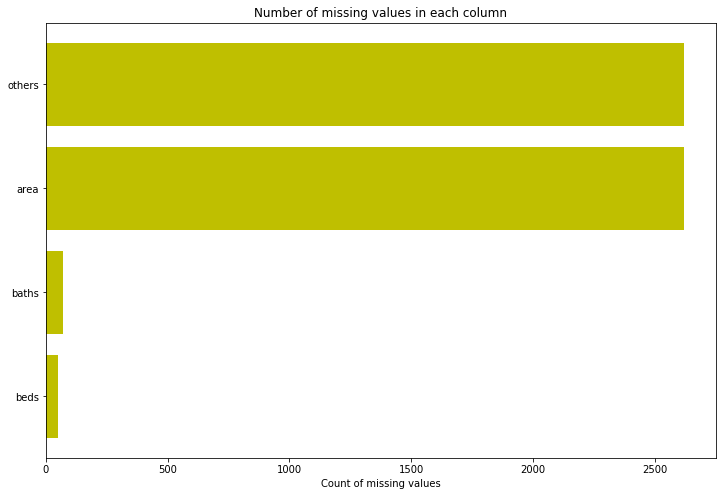

In [9]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,8))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [10]:
print(df.isnull().sum())

link            0
title           0
postdate        0
latitude        0
longitude       0
beds           49
baths          70
area         2619
others       2619
price           0
dtype: int64


In [11]:
df.describe()

,beds,baths,area,price
count,3541.000000,3520.000000,971.000000,3590.000000
mean,4.358656,1.283097,935.870237,1957.106964
std,44.113831,0.577632,421.066363,5223.785932
min,0.000000,0.000000,235.000000,0.000000
25%,1.000000,1.000000,671.500000,1200.000000
50%,2.000000,1.000000,826.000000,1675.000000
75%,2.000000,1.500000,1138.000000,2382.500000
max,1502.000000,5.000000,4299.000000,309900.000000


Aha! Apartment with 1502 bed? and maximum price of $309900 and minimum is 0 ? That definitely raises red flag. Let's examine each of them more closely. 

In [12]:
df[df['beds'] > 10].head()

,link,title,postdate,latitude,longitude,beds,baths,area,others,price
1139,https://chicago.craigslist.org/chc/apa/d/chica...,Prime in Lake View - 3257 N. Sheffield #3257-110,Apr 11,41.941832,-87.654454,175.0,NaN,NaN,NaN,595
1145,https://chicago.craigslist.org/chc/apa/d/chica...,Prime in Lake View - 3355 N. Clark Ave. #1S,Apr 11,41.943733,-87.653915,560.0,NaN,NaN,NaN,795
1158,https://chicago.craigslist.org/chc/apa/d/chica...,Prime Lake View Location - 3257 N. Sheffield #101,Apr 11,41.941832,-87.654454,200.0,NaN,NaN,NaN,740
1187,https://chicago.craigslist.org/chc/apa/d/chica...,Prime Lake View Location - 3355 N. Clark Ave. #1S,Apr 11,41.943733,-87.653915,560.0,NaN,NaN,NaN,795
1191,https://chicago.craigslist.org/chc/apa/d/chica...,Stunning Lake View - 3257 N. Sheffield #3257-110,Apr 11,41.941832,-87.654454,175.0,NaN,NaN,NaN,595


It seems like area and beds were incorrectly posted/scraped. Let's see how many such listings are there. 

In [13]:
df[df['beds'] > 10].shape[0]

21

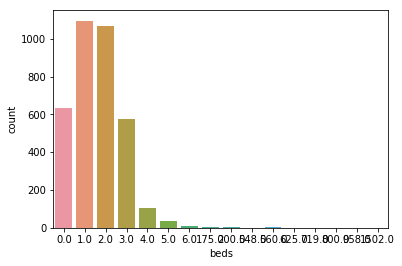

In [14]:
sns.countplot(x='beds', data = df)

There are 21 such entires and there is certainly problem with these listings. Since they are obvious outliers, we can get rid of these entries.  

In [15]:
df = df[(df['beds'] < 10)]

#### Let's also look at the price more closely. 

In [16]:
df[(df['price'] > 10000) | (df['price'] < 100)].head()

,link,title,postdate,latitude,longitude,beds,baths,area,others,price
1387,https://chicago.craigslist.org/chc/apa/d/chica...,3 BEDROOM SECTION 8 KIMBALL & MONTROSE,Apr 11,41.962931,-87.713357,3.0,0.0,NaN,NaN,0
1396,https://chicago.craigslist.org/chc/apa/d/chica...,1 BEDROOM SECTION 8. KIMBALL AND IRVING,Apr 11,41.955631,-87.715457,1.0,0.0,NaN,NaN,0
1404,https://chicago.craigslist.org/chc/apa/d/chica...,3 BEDROOM SECTION 8 KIMBALL & MONTROSE,Apr 11,41.962931,-87.713357,3.0,0.0,NaN,NaN,0
1961,https://chicago.craigslist.org/chc/apa/d/chica...,2 BEDROOM SECTION 8 LAWRENCE AND PULASKI,Apr 12,41.966331,-87.723058,2.0,1.0,NaN,NaN,0
1962,https://chicago.craigslist.org/chc/apa/d/one-b...,ONE BEDROOM SECTION 8 WHEELCHAIR KEDZIE AND ...,Apr 12,41.978762,-87.706947,1.0,1.0,NaN,NaN,0


In [17]:
df[(df['price'] > 10000) | (df['price'] < 100)].shape[0]

10

Since we are certain that there is defnite problem with these outliers, we can get rid of these listings from further analysis.

In [18]:
df = df[(df['price'] < 10000) & (df['price'] > 100)]

### Count plots for beds and baths

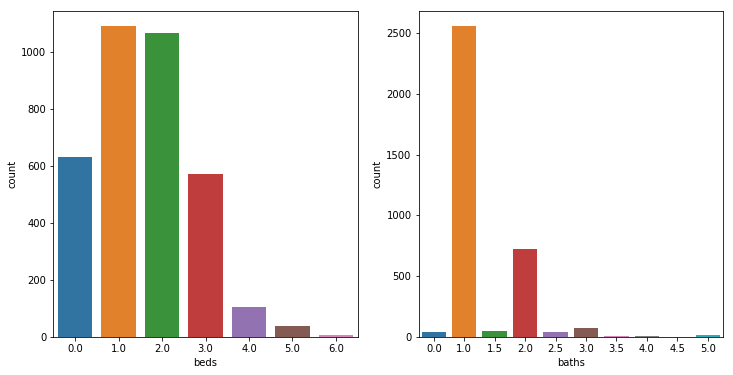

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='beds', data = df, ax = ax[0])
sns.countplot(x='baths', data = df, ax = ax[1])
plt.show()

In [20]:
import plotly.plotly as py
import plotly.graph_objs as go
mapbox_access_token = "pk.eyJ1IjoiZGlwYWtyaW1hbCIsImEiOiJjanR0NHp5Z3gxOGVtNGVsbHIxOGI3ZmV6In0.bmrI81LR7L441sUKqDeKmw" 
df['text'] = 'price: $' + df['price'].astype(str) + '<br>Beds: ' + (df['beds']).astype(str) \
            + '<br> Baths: ' + (df['baths']).astype(str)
data = [
    go.Scattermapbox(
        lat=df['latitude'],
        lon=df['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(255, 150, 100)',
            opacity=0.7
        ),
        text = df['text'] ,
        hoverinfo='text'
    )
]

layout = go.Layout(
    title = "Chicago Rental Listings",
    width=800,
    height=600,
    showlegend=False,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=41.9,
            lon=-87.7
        ),
        pitch=10,
        zoom=9,
        style='outdoors'
    ),
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Chicago_Rental_listings')

In [21]:
df.isna().sum()

link            0
title           0
postdate        0
latitude        0
longitude       0
beds            0
baths           0
area         2540
others       2540
price           0
text            0
dtype: int64

In [22]:
#df['longitude'].value_counts().hist()
df['longitude'] = df['longitude'].replace('','NaN').fillna(df['longitude'].mode()[0]).astype('float')
df['latitude'] = df['latitude'].replace('', 'NaN').fillna(df['latitude'].mode()[0]).astype('float')

In [23]:
def get_distance_from_union_station(lon2, lat2):
    # convert decimal degrees to radians
    lon1 = -87.6403
    lat1 = 41.8787 
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 3956 # Radius of earth in miles 
    return c * r

In [24]:
#df['distance_from_us'] = df.apply(lambda x: get_distance_from_union_station(x['longitude'], x['latitude']), axis=1)

In [25]:
df['distance_from_us'] = get_distance_from_union_station(df['longitude'].values, df['latitude'].values)

The parameters (mean(mu) and sigma (std) of the normal fit are:

 mu = 1886.42 and sigma = 907.34



Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Rental Price Distribution')

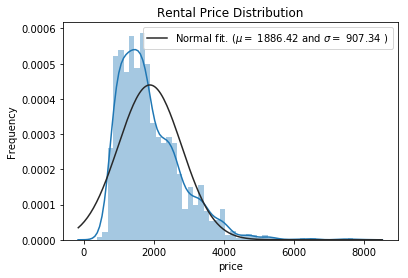

In [26]:
fig= plt.figure()
sns.distplot(df['price'], fit=norm)
(mu, sigma) = norm.fit(df['price'])
print("The parameters (mean(mu) and sigma (std) of the normal fit are:")
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal fit. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rental Price Distribution')
plt.show()

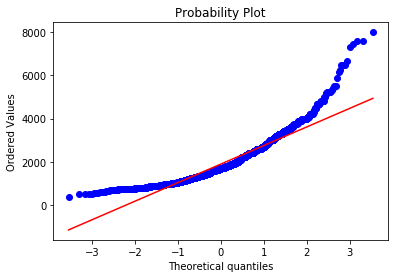

In [27]:
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show();

The distribution is right-skewed. Since the linear models work well with normal distributed data we want to transform the price variable to make it more normally distributed. Let's see if log transform helps here. 

The parameters (mean(mu) and sigma (std) of the normal fit are:

 mu = 7.44 and sigma = 0.45



Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Rental Price Distribution')

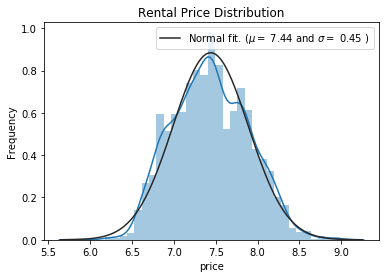

In [28]:
fig= plt.figure()
sns.distplot(np.log(df['price']), fit=norm)
(mu, sigma) = norm.fit(np.log(df['price']))
print("The parameters (mean(mu) and sigma (std) of the normal fit are:")
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal fit. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rental Price Distribution')
plt.show()

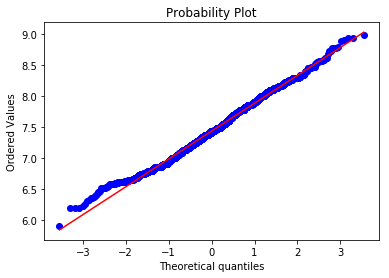

In [29]:
fig = plt.figure()
res = stats.probplot(np.log(df['price']), plot=plt)
plt.show();

In [30]:
df['price'] = df.apply(lambda x : np.log(x["price"]), axis=1)

That certainly helps. 

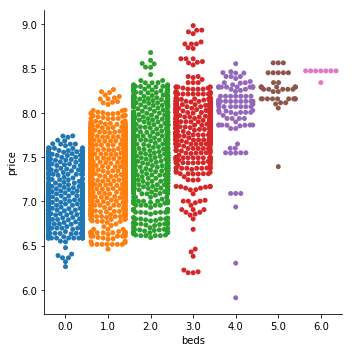

In [31]:
sns.catplot(x="beds", y="price", kind="swarm", data=df);

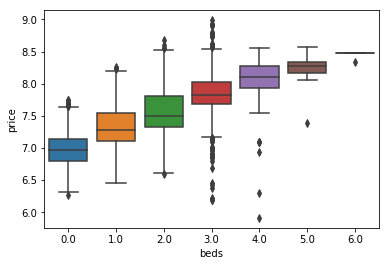

In [32]:
ax = sns.boxplot(x="beds", y="price", data=df)

In [33]:
df[df['distance_from_us'] > 200].head(2)

,link,title,postdate,latitude,longitude,beds,baths,area,others,price,text,distance_from_us
1682,https://chicago.craigslist.org/chc/apa/d/on-si...,"On-site management, Oversized windows, Walk to...",Apr 11,30.976655,-65.434713,0.0,1.0,390.0,"[available apr 9, cats are OK - purrr, dogs ar...",7.081709,price: $1190<br>Beds: 0.0<br> Baths: 1.0,1438.579749
2861,https://chicago.craigslist.org/chc/apa/d/steps...,"Steps to park, lake and beach, On-site managem...",Apr 12,30.976655,-65.434713,0.0,1.0,370.0,"[available apr 12, cats are OK - purrr, dogs a...",7.096721,price: $1208<br>Beds: 0.0<br> Baths: 1.0,1438.579749


In [34]:
pd.set_option('display.max_colwidth', -1)
print(df[df['distance_from_us'] > 200]['link'].to_string())

1682    https://chicago.craigslist.org/chc/apa/d/on-site-management-oversized-windows/6862040819.html
2861    https://chicago.craigslist.org/chc/apa/d/steps-to-park-lake-and-beach-on-site/6864455874.html
3186    https://chicago.craigslist.org/chc/apa/d/studio-and-convertible-studio/6859728377.html       
3523    https://chicago.craigslist.org/chc/apa/d/direct-debit-available-gas-ranges/6864505207.html   


These appear to be genuine listing but for some reason the latitude and longitude information is in Bermuda! Damn!Let's throw away these listings for now. 

In [35]:
df = df[df['distance_from_us'] < 25]

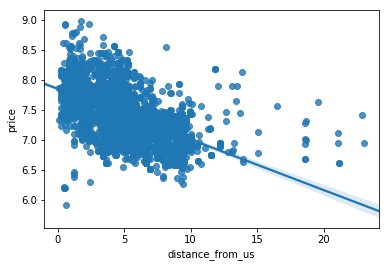

In [36]:
sns.regplot(x='distance_from_us', y = 'price', data = df)

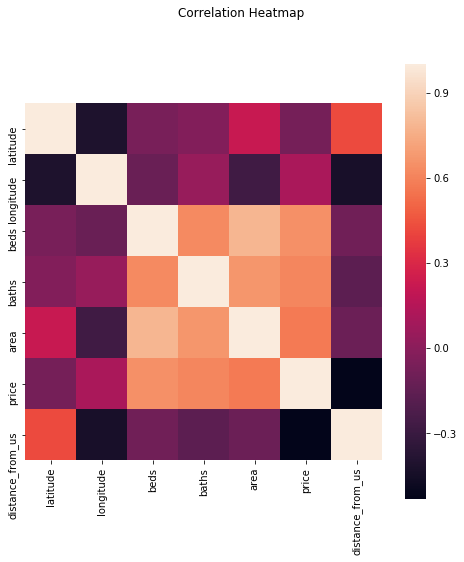

In [37]:
#pd.set_option('precision',3)
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), square=True)
plt.suptitle("Correlation Heatmap")
plt.show();

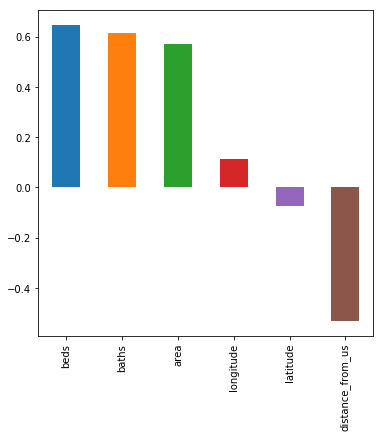

In [38]:
corr_with_rental_price = df.corr()["price"].sort_values(ascending=False)
plt.figure(figsize=(6,6))
corr_with_rental_price.drop("price").plot.bar()
plt.show();

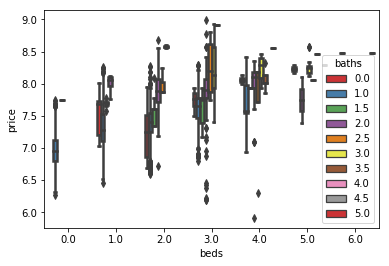

In [39]:
ax = sns.boxplot(x="beds", y="price", hue = "baths", data=df, palette="Set1", linewidth=2.5)

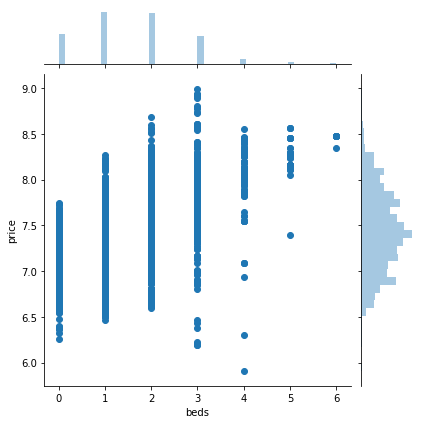

In [40]:
sns.jointplot(x="beds", y="price", data=df);

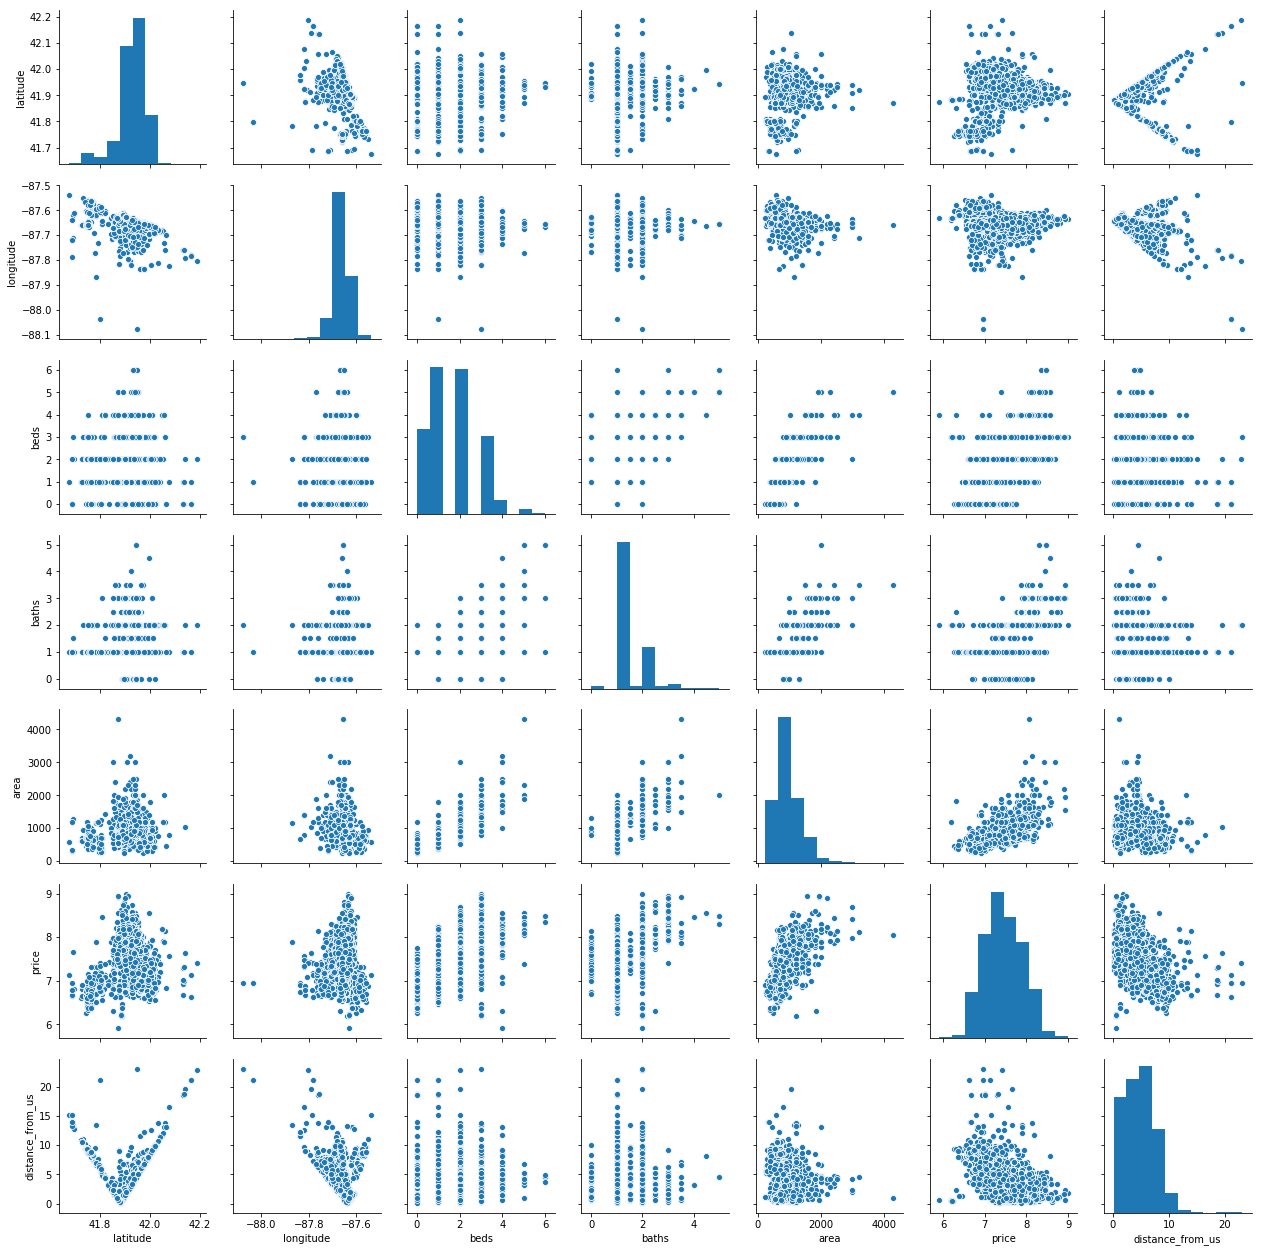

In [41]:
sns.pairplot(df);

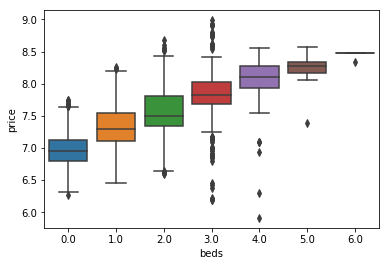

In [42]:
ax = sns.boxplot(x="beds", y="price", data=df)

In [43]:
df.isna().sum()
features = ['beds', 'baths', 'distance_from_us', ]

X = df[features]
y = df['price']

link                0   
title               0   
postdate            0   
latitude            0   
longitude           0   
beds                0   
baths               0   
area                2540
others              2540
price               0   
text                0   
distance_from_us    0   
dtype: int64

In [44]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.25, random_state = 19)

In [45]:
X.head()

,beds,baths,distance_from_us
0,3.0,2.0,4.582561
1,3.0,1.0,4.031595
2,0.0,1.0,7.922689
3,1.0,1.0,5.269553
4,3.0,2.0,1.400034


In [46]:
from sklearn.dummy import DummyRegressor
dummy_median = DummyRegressor(strategy='mean')
dummy_regressor = dummy_median.fit(X_train,y_train)
dummy_predicts = dummy_regressor.predict(X_test)
print("Model Accuracy:", dummy_regressor.score(X_test,y_test)*100)

Model Accuracy: -0.22926498680544416


In [47]:
print('$',mean_absolute_error(y_test,dummy_predicts))

$ 0.3709278449440895


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

score on training 0.9613348630785962
r2 score 0.806642895512427
DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=100, splitter='best')


DecisionTreeRegressor(criterion='mse', max_depth=11, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=100, splitter='best')

score on training 0.9224970095765208
r2 score 0.7790833571445632
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=12, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=12, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

score on training 0.9851416433232858
r2 score 0.7874185223254722


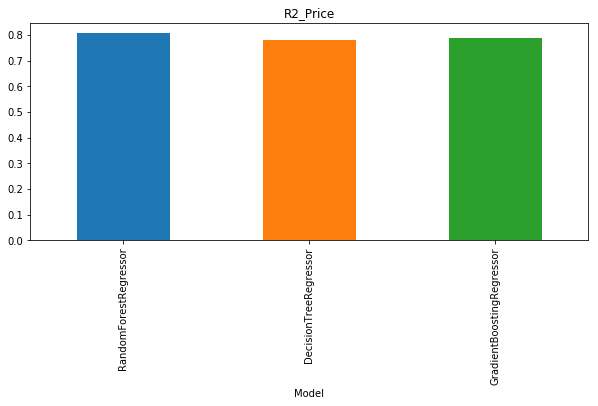

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [RandomForestRegressor(n_estimators=200,criterion='mse',max_depth=20,random_state=100),DecisionTreeRegressor(criterion='mse',max_depth=11,random_state=100),GradientBoostingRegressor(n_estimators=200,max_depth=12)]
learning_mods = pd.DataFrame()
temp = {}
#run through models
for model in models:
    print(model)
    m = str(model)
    temp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    temp['R2_Price'] = r2_score(y_test, model.predict(X_test))
    print('score on training',model.score(X_train, y_train))
    print('r2 score',r2_score(y_test, model.predict(X_test)))
    learning_mods = learning_mods.append([temp])
learning_mods.set_index('Model', inplace=True)
 
fig, axes = plt.subplots(ncols=1, figsize=(10, 4))
learning_mods.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

<Figure size 1152x432 with 0 Axes>

<BarContainer object of 3 artists>

([<matplotlib.axis.XTick at 0x1a250340f0>,
 <a list of 3 Text xticklabel objects>)

Text(0.5, 1.0, 'Feature Importance')

Text(0, 0.5, 'Importance')

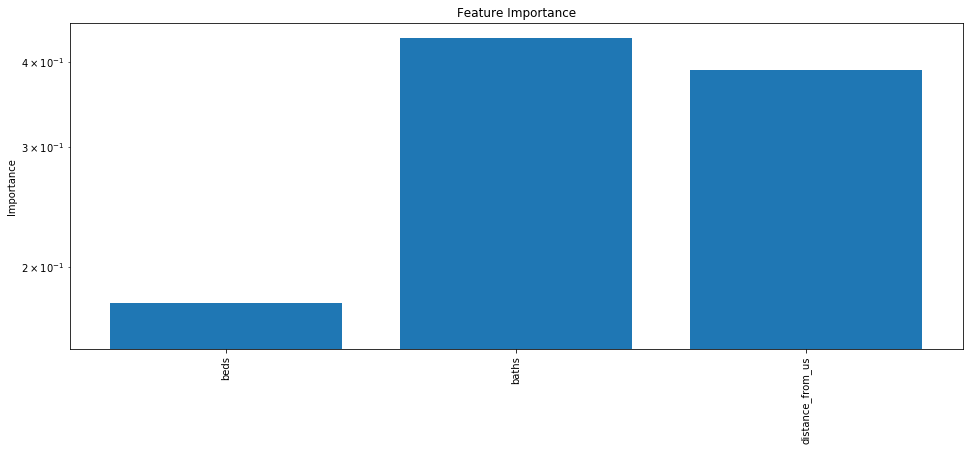

In [49]:
regressionTree_imp = model.feature_importances_
plt.figure(figsize=(16,6))
plt.yscale('log',nonposy='clip')
plt.bar(range(len(regressionTree_imp)),regressionTree_imp,align='center')
plt.xticks(range(len(regressionTree_imp)),features,rotation='vertical')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()

In [50]:
print("r2-score on test....%s " %r2_score (y_test, model.predict(X_test)))

r2-score on test....0.7874185223254722 


In [51]:
X_test.shape, y_test.shape

((870, 3), (870,))

Text(0.5, 0, 'Prices: $Y_i$')

Text(0, 0.5, 'Predicted prices: $\\hat{Y}_i$')

Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

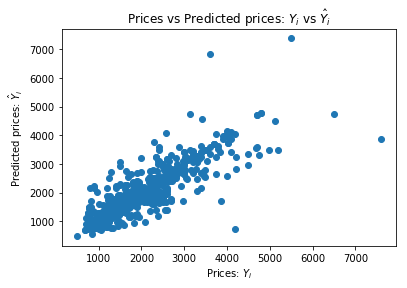

In [52]:
Y_pred_test = model.predict(X_test)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.scatter(np.exp(y_test), np.exp(Y_pred_test))
#plt.xlim(0, 5000)
#plt.ylim(0, 5000)
plt.show()


In [53]:
valid = np.asarray([2, 1, 14]).reshape(1, -1)
print(np.exp(model.predict(valid)))

[1049.27492584]
